# Final Assessment: Cross-Modal Projection
This notebook implements the final assessment task: classifying RGB images using a classifier trained *only* on LiDAR data.
This is achieved by:
1.  **LiDAR Classifier**: Training a classifier on LiDAR range images.
2.  **CILP (Contrastive Image-LiDAR Pretraining)**: Aligning RGB and LiDAR embeddings using a contrastive loss (CLIP-style).
3.  **Cross-Modal Projector**: Training a projector to map aligned RGB embeddings to the LiDAR classifier's embedding space.
4.  **Zero-Shot/Proxy Classification**: Classifying RGB images by projecting them to the LiDAR space and using the frozen LiDAR classifier.

The models are defined in `src/models.py` and training utilities in `src/training.py`.


## Setup
The usual drive, import and reproducability setup.

In [2]:
from pathlib import Path
import sys
import os
try:
    from google.colab import drive
    drive.mount('/gdrive')
    print("Mounted Google Drive")
    DATA_DIR = Path('/gdrive/MyDrive/extended_assessments/Multimodal_Learning/data')
    sys.path.append(os.path.abspath('/gdrive/MyDrive/extended_assessments/Multimodal_Learning'))
except:
    print("Running locally")
    DATA_DIR = Path('../data')
    sys.path.append(os.path.abspath('../.'))
print(f"Using {DATA_DIR} as data source")

Running locally
Using ../data as data source


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import random
import wandb

from src.datasets import CubesAndShperesDataset
from src.models import Embedder, EmbedderStrided, ContrastivePretraining, Projector, RGB2LiDARClassifier
from src.training import train_classifier, train_cilp, train_projector
from src.visualization import plot_losses


BATCH_SIZE = 32
WANDB_ENTITY = "jan-kubeler-hpi"
WANDB_PROJECT = "clip-extended-assessment"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [4]:
def set_seeds(seed=51):
    """
    Set seeds for complete reproducibility across all libraries and operations.

    Args:
        seed (int): Random seed value
    """
    # Set environment variables before other imports
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'

    # Python random module
    random.seed(seed)

    # NumPy
    np.random.seed(seed)

    # PyTorch CPU
    torch.manual_seed(seed)

    # PyTorch GPU (all devices)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

        # CUDA deterministic operations
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # PyTorch deterministic algorithms (may impact performance)
    try:
        torch.use_deterministic_algorithms(True)
    except RuntimeError:
        # Some operations don't have deterministic implementations
        print("Warning: Some operations may not be deterministic")

    print(f"All random seeds set to {seed} for reproducibility")


set_seeds(51)

All random seeds set to 51 for reproducibility


## Dataset and DataLoader
Same as for the previous notebooks.

In [ ]:
# load precomputed dataset
import pickle
with open("/gdrive/MyDrive/extended_assessments/Multimodal_Learning/notebooks/dataset_precomputed.pkl", "rb") as f:
    data = pickle.load(f)
train_indices = data["train_indices"]
val_indices = data["val_indices"]
train_dataset = data["train_dataset"]
val_dataset = data["val_dataset"]

In [5]:
# Build Datasets
full_dataset = CubesAndShperesDataset(DATA_DIR)

# Split into Train and Validation (No Test)
# Logic from 05_Assessment.ipynb: Last VALID_BATCHES * BATCH_SIZE are validation

total_len = len(full_dataset)
n_classes = 2
samples_per_class = total_len // n_classes

VALID_BATCHES = 10
valid_samples_per_class = VALID_BATCHES * BATCH_SIZE
train_samples_per_class = samples_per_class - valid_samples_per_class

train_indices = []
val_indices = []
for i in range(n_classes):
    start_idx = i * samples_per_class
    train_indices.extend(range(start_idx, start_idx + train_samples_per_class))
    val_indices.extend(range(start_idx + train_samples_per_class, start_idx + samples_per_class))

from torch.utils.data import Subset
train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)

Constructing Dataset for class cubes


Files for class: 100%|██████████| 9999/9999 [00:10<00:00, 942.54it/s] 


Constructing Dataset for class spheres


Files for class: 100%|██████████| 10029/10029 [00:10<00:00, 936.48it/s]


In [ ]:
import pickle
with open("dataset_precomputed.pkl", "wb") as f:
    pickle.dump({
        "train_indices": train_indices,
        "val_indices": val_indices,
        "train_dataset": train_dataset,
        "val_dataset": val_dataset
    }, f)

In [6]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Total samples: {len(train_dataset) + len(val_dataset)}")
print(f"Train size: {len(train_dataset)}")
print(f"Val size: {len(val_dataset)}")

Total samples: 19998
Train size: 19358
Val size: 640


## 2. Train LiDAR Classifier (Pre-requisite)
We first need a pre-trained LiDAR classifier to act as our target for the cross-modal projection. We will use the `EmbedderStrided` architecture as it offered a slightly better performance in the previous experiment.

In [7]:
lidar_cnn = EmbedderStrided(in_ch=4, out_dim=2).to(device)
optimizer_lidar = Adam(lidar_cnn.parameters(), lr=0.0001)
criterion_lidar = nn.CrossEntropyLoss()

# Train LiDAR Classifier
lidar_cnn = train_classifier(lidar_cnn, train_loader, optimizer_lidar, criterion_lidar, epochs=5, device=device)

# Freeze LiDAR CNN
for param in lidar_cnn.parameters():
    param.requires_grad = False
lidar_cnn.eval()
print("LiDAR Classifier trained and frozen.")

Training Classifier...
Epoch 1/5, Loss: 0.1306, Acc: 92.64%
Epoch 2/5, Loss: 0.0110, Acc: 99.64%
Epoch 3/5, Loss: 0.0071, Acc: 99.80%
Epoch 4/5, Loss: 0.0066, Acc: 99.83%
Epoch 5/5, Loss: 0.0120, Acc: 99.67%
LiDAR Classifier trained and frozen.


## 3. Contrastive Image-LiDAR Pre-training (CILP)
We will train a CILP model to align RGB and LiDAR embeddings. We use `EmbedderStrided` for both modalities.

In [8]:
CILP_EMB_SIZE = 200
cilp_model = ContrastivePretraining(embedding_size=CILP_EMB_SIZE, embedder_type='strided').to(device)

wandb: Currently logged in as: jan-kubeler (gorillawatch) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Starting CILP Training...
Epoch 1/10: Train Loss 0.8411, Valid Loss 0.5127
Epoch 2/10: Train Loss 0.3576, Valid Loss 0.3789
Epoch 3/10: Train Loss 0.2693, Valid Loss 0.3002
Epoch 4/10: Train Loss 0.2040, Valid Loss 0.2621
Epoch 5/10: Train Loss 0.1656, Valid Loss 0.2304
Epoch 6/10: Train Loss 0.1445, Valid Loss 0.2331
Epoch 7/10: Train Loss 0.1292, Valid Loss 0.1897
Epoch 8/10: Train Loss 0.1048, Valid Loss 0.1770
Epoch 9/10: Train Loss 0.1076, Valid Loss 0.1642
Epoch 10/10: Train Loss 0.0846, Valid Loss 0.1609


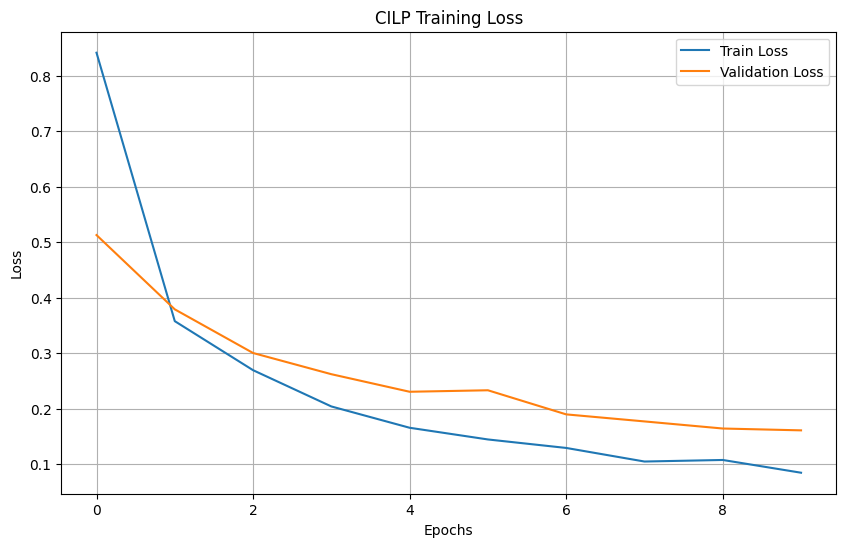

In [9]:
wandb.init(project="clip-extended-assessment", name="cilp-training", entity="jan-kubeler-hpi", config={
    "task": "CILP",
    "embedding_size": CILP_EMB_SIZE,
    "batch_size": BATCH_SIZE,
    "learning_rate": 0.0001,
    "epochs": 10
})

optimizer_cilp = Adam(cilp_model.parameters(), lr=0.0001)
train_losses, valid_losses = train_cilp(cilp_model, train_loader, val_loader, optimizer_cilp, epochs=10, device=device, use_wandb=True)

# Plot
plot_losses(train_losses, valid_losses, title="CILP Training Loss")

# Freeze CILP
for param in cilp_model.parameters():
    param.requires_grad = False

## 4. Cross-Modal Projector
Train a projector to map RGB embeddings (from CILP) to LiDAR embeddings (from the pre-trained LiDAR classifier).

Training Projector...
Epoch 1, Projector Loss: 2.0463
Epoch 2, Projector Loss: 1.0342
Epoch 3, Projector Loss: 0.9587
Epoch 4, Projector Loss: 0.9289
Epoch 5, Projector Loss: 0.8912
Epoch 6, Projector Loss: 0.8661
Epoch 7, Projector Loss: 0.8439
Epoch 8, Projector Loss: 0.8324
Epoch 9, Projector Loss: 0.8148
Epoch 10, Projector Loss: 0.8072
Epoch 11, Projector Loss: 0.7988
Epoch 12, Projector Loss: 0.7879
Epoch 13, Projector Loss: 0.7740
Epoch 14, Projector Loss: 0.7697
Epoch 15, Projector Loss: 0.7599


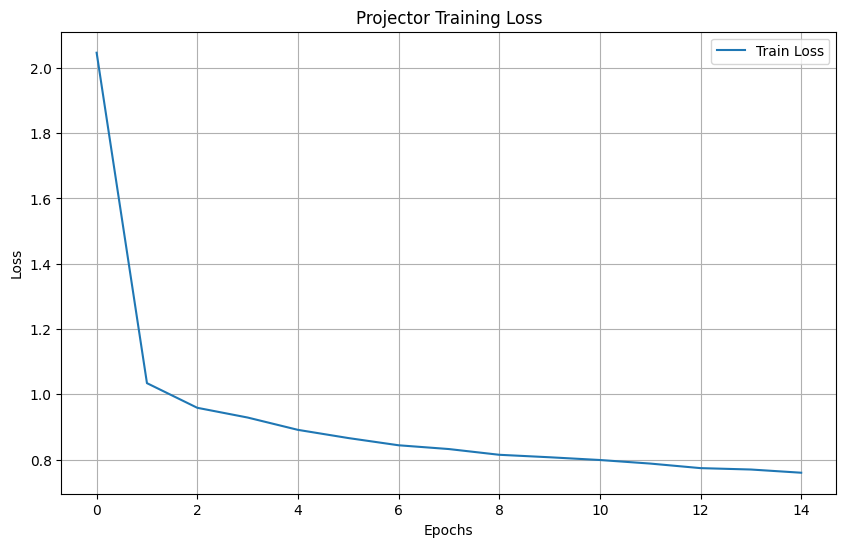

In [ ]:
# Projector maps CILP RGB embeddings (200) to LiDAR Classifier embeddings (100)
projector = Projector(input_dim=CILP_EMB_SIZE, output_dim=100).to(device)
optimizer_proj = Adam(projector.parameters(), lr=0.0005)
criterion_proj = nn.MSELoss()

proj_losses = train_projector(projector, cilp_model, lidar_cnn, train_loader, optimizer_proj, criterion_proj, epochs=15, device=device, use_wandb=True)

plot_losses(proj_losses, title="Projector Training Loss")

## 5. Final RGB2LiDAR Classifier
Combine the pieces to classify RGB images using the LiDAR classifier.

In [11]:
final_model = RGB2LiDARClassifier(cilp_model.img_embedder, projector, lidar_cnn).to(device)

final_model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

similarity_matrix = None

with torch.no_grad():
    # Calculate accuracy
    for batch in val_loader:
        rgb, _, label = batch
        rgb, label = rgb.to(device), label.to(device).long().squeeze()
        
        output = final_model(rgb)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(label.cpu().numpy())

    # Calculate similarity matrix on one batch for visualization
    rgb_batch, lidar_batch, _ = next(iter(val_loader))
    rgb_batch, lidar_batch = rgb_batch.to(device), lidar_batch.to(device)
    logits_per_img, _ = cilp_model(rgb_batch, lidar_batch)
    similarity_matrix = logits_per_img.cpu().numpy()

acc = 100 * correct / total
print(f"Final Accuracy on RGB images (using LiDAR proxy): {acc:.2f}%")

wandb.log({
    "final_accuracy": acc,
    "similarity_matrix": wandb.Image(similarity_matrix, caption="CILP Similarity Matrix (Validation Batch)")
})
wandb.finish()

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


Final Accuracy on RGB images (using LiDAR proxy): 98.59%


cilp_epoch,▁▂▃▃▄▅▆▆▇█
cilp_train_loss,█▄▃▂▂▂▁▁▁▁
cilp_val_loss,█▅▄▃▂▂▂▁▁▁
final_accuracy,▁
projector_epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
projector_loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁
cilp_epoch,10
cilp_train_loss,0.08461
cilp_val_loss,0.16092
final_accuracy,98.59375
projector_epoch,15


## 6. Save Model Checkpoint

In [ ]:
torch.save({
    'cilp_model': cilp_model.state_dict(),
    'projector': projector.state_dict(),
    'final_model': final_model.state_dict()
}, '../checkpoints/assessment_checkpoint.pt')
print("Model saved.")

Model saved.
